# Data Preparation and Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_json("data/data.jsonl", lines=True)
data

,question_id,question,human_answer,ai_answer
0,927358,How do I undo the most recent local commits in...,"Undo a commit & redo\n$ git commit -m ""Somethi...",\nThe easiest way to undo the most recent loca...
1,2003505,How do I delete a Git branch locally and remot...,Executive Summary\ngit push -d <remote_name> <...,\n1. Delete the local branch:\ngit branch -d <...
2,292357,What is the difference between 'git pull' and ...,"In the simplest terms, git pull does a git fet...",\nGit pull is a combination of git fetch and g...
3,477816,Which JSON content type do I use?\n\nThere are...,For JSON text:\napplication/json\n\n\nThe MIME...,\nThe most widely used and supported JSON cont...
4,5767325,How can I remove a specific item from an array...,Find the index of the array element you want t...,\nYou can use the Array.prototype.filter() met...
...,...,...,...,...
8633,5143769,How do I check if a given Python string is a s...,Try using in like this:\n\n>>> x = 'hello'\n>>...,"\nYes, Python has a built-in method called the..."
8634,5878697,How do I remove blank elements from an array?\...,"There are many ways to do this, one is reject\...","\nYes, you can use the Array.filter() method t..."
8635,7054972,Java system properties and environment variabl...,I think the difference between the two boils d...,\nSystem properties (System.getProperties()) a...
8636,7785374,How to prevent column break within an element?...,The correct way to do this is with the break-i...,\nTo prevent the column break within an elemen...


## Cleanup

We immediately see, that ai answers tend to start with newline, so let's strip whitespaces from both answers columns

In [3]:
data.human_answer = data.human_answer.str.strip()
data.ai_answer = data.ai_answer.str.strip()

## Removing duplicates

In [4]:
data.duplicated(subset='question_id').sum()

30

In [5]:
data.drop_duplicates(subset=['question_id'], keep='last', inplace=True)

## Labeling
Here I'm splitting the dataset into two equal parts (with odd and even numbers), one of which will be labeled with 1 and contain the answer from AI and the other - with 0 and answer from Stackoverflow

In [6]:
labeled_data = data.copy()
labeled_data['target'] = labeled_data.apply(lambda x: x.name % 2, axis=1)
labeled_data['answer'] = labeled_data.apply(lambda x: x.ai_answer if x.target==1 else x.human_answer, axis=1)
labeled_data.drop('ai_answer', axis=1, inplace=True)
labeled_data.drop('human_answer', axis=1, inplace=True)
labeled_data

,question_id,question,target,answer
0,927358,How do I undo the most recent local commits in...,0,"Undo a commit & redo\n$ git commit -m ""Somethi..."
1,2003505,How do I delete a Git branch locally and remot...,1,1. Delete the local branch:\ngit branch -d <br...
2,292357,What is the difference between 'git pull' and ...,0,"In the simplest terms, git pull does a git fet..."
3,477816,Which JSON content type do I use?\n\nThere are...,1,The most widely used and supported JSON conten...
4,5767325,How can I remove a specific item from an array...,0,Find the index of the array element you want t...
...,...,...,...,...
8633,5143769,How do I check if a given Python string is a s...,1,"Yes, Python has a built-in method called the ""..."
8634,5878697,How do I remove blank elements from an array?\...,0,"There are many ways to do this, one is reject\..."
8635,7054972,Java system properties and environment variabl...,1,System properties (System.getProperties()) are...
8636,7785374,How to prevent column break within an element?...,0,The correct way to do this is with the break-i...


Let's double check we don't have question duplicates:

In [7]:
labeled_data.duplicated(subset='question_id').sum()

0

## Tokenizing questions and answers
To handle the text data it's convenient to tokenize it, i.e. split into separate words (tokens). We'll also immediately stem the tokens, so that different forms of the same word become a single token

In [8]:
from nltk.stem import SnowballStemmer

In [9]:
stemmer = SnowballStemmer(language='english')

In [10]:
labeled_data['tokenized_answer'] = labeled_data.answer.apply(lambda x: [stemmer.stem(w) for w in x.split()])
labeled_data['tokenized_question'] = labeled_data.question.apply(lambda x: [stemmer.stem(w) for w in x.split()])
labeled_data[['tokenized_answer', 'tokenized_question']]

,tokenized_answer,tokenized_question
0,"[undo, a, commit, &, redo, $, git, commit, -m,...","[how, do, i, undo, the, most, recent, local, c..."
1,"[1., delet, the, local, branch:, git, branch, ...","[how, do, i, delet, a, git, branch, local, and..."
2,"[in, the, simplest, terms,, git, pull, doe, a,...","[what, is, the, differ, between, git, pull, an..."
3,"[the, most, wide, use, and, support, json, con...","[which, json, content, type, do, i, use?, ther..."
4,"[find, the, index, of, the, array, element, yo...","[how, can, i, remov, a, specif, item, from, an..."
...,...,...
8633,"[yes,, python, has, a, built-in, method, call,...","[how, do, i, check, if, a, given, python, stri..."
8634,"[there, are, mani, way, to, do, this,, one, is...","[how, do, i, remov, blank, element, from, an, ..."
8635,"[system, properti, (system.getproperties()), a...","[java, system, properti, and, environ, variabl..."
8636,"[the, correct, way, to, do, this, is, with, th...","[how, to, prevent, column, break, within, an, ..."


Later we'll need also stemmed answer as a string

In [11]:
labeled_data['stemmed_answer'] = labeled_data.tokenized_answer.apply(lambda x: ' '.join(x))
labeled_data['stemmed_answer']

0       undo a commit & redo $ git commit -m "someth t...
1       1. delet the local branch: git branch -d <bran...
2       in the simplest terms, git pull doe a git fetc...
3       the most wide use and support json content typ...
4       find the index of the array element you want t...
                              ...                        
8633    yes, python has a built-in method call the "in...
8634    there are mani way to do this, one is reject n...
8635    system properti (system.getproperties()) are a...
8636    the correct way to do this is with the break-i...
8637    a = (true ? 5 : 10) # => a = 5 a = (fals ? 5 :...
Name: stemmed_answer, Length: 8608, dtype: object

## Feature Engineering
I have several hypotheses about the behaviour of GPT:
1. It tends to repeat parts of the question in its answer
2. Its own vocabulary is smaller and less variate comparing to average human's
3. The size of the answers is less variate than that of humans'

Keeping these in mind I'll create several numerical features and later try to train a regression model on them.

### Helpers

In [12]:
import matplotlib.pyplot as plt

def comparation_hist(column, value_name, bins=30):
    plt.hist(labeled_data[labeled_data.target==0][column], alpha=0.5, label='Human', bins = 30)
    plt.hist(labeled_data[labeled_data.target==1][column], alpha=0.5, label='AI', bins = 30)

    # plt.title('Histograms for col1 and col2')
    plt.xlabel(value_name)
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

### Feature: Creativity
I'm introducing the term creativity to describe how many original words are used in the answer. Hence the feature:
* `creativity` - number of all unique words in the answer that are not present in the question, divided by the size of the answer

In [13]:
labeled_data['new_words'] = labeled_data.apply(lambda x: set([w for w in x.tokenized_answer if w not in x.tokenized_question]), axis=1)
labeled_data['creativity'] = labeled_data.apply(lambda x: len(x.new_words) / len(x.tokenized_answer) if len(x.tokenized_answer)>0 else 0, axis=1)

In [14]:
labeled_data.creativity.mean()

0.4848950193107679

In [15]:
labeled_data[labeled_data.target==0].creativity.mean(), labeled_data[labeled_data.target==1].creativity.mean()


(0.5449938239619055, 0.42479621465963024)

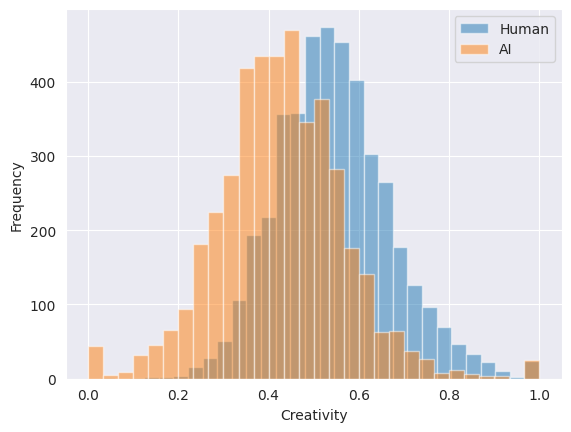

In [16]:
comparation_hist('creativity', 'Creativity')

There is obviously a difference in creativity between humans and AI

### Feature: Vocabulary Size
Assuming that number of unique words may be different in human and AI answers, I'm introducing two more features:
* `n_unique_words` - number of unique words in the answer
* `vocabulary_size` - `unique_words` divided by the size of the tokenized answer

In [17]:
labeled_data['n_unique_words'] = labeled_data.tokenized_answer.apply(lambda x: len(set(x)))
labeled_data['vocabulary_size'] = labeled_data.apply(lambda x: x.n_unique_words / len(x.tokenized_answer) if len(x.tokenized_answer)>0 else 0, axis=1)

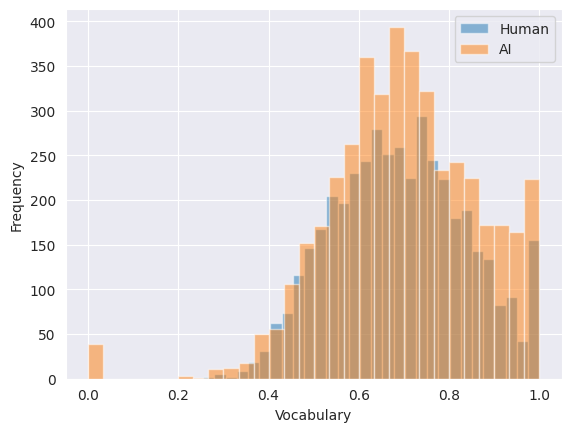

In [18]:
comparation_hist('vocabulary_size', 'Vocabulary')

This metric doesn't seem to be of any value

### Feature: Stealing
Opposite to creativity, stealing shows how many words sequences were stolen from the question and taken into the answer. I'm breaking questions and answers into n-grams (word sequences of length n) and then find the common ngrams. Then I create two features:

* `stealing_strength` - maximum length (number of words) of a stolen ngram
* `stealing_frequency` - total number of stolen ngrams divided by number of unique words

In [19]:
from nltk import everygrams

In [20]:
def find_stolen_ngrams(record):
    ngrams_question = everygrams(record.tokenized_question, min_len=2)
    ngrams_answer = everygrams(record.tokenized_answer, min_len=2)
    ngrams_set = set(ngrams_question).intersection(ngrams_answer)

    return ngrams_set

In [21]:
%%time
labeled_data['stolen_ngrams'] = labeled_data.apply(find_stolen_ngrams, axis=1)

CPU times: user 2min 30s, sys: 1.8 s, total: 2min 32s
Wall time: 2min 32s


In [55]:
labeled_data['stealing_strength'] = np.log1p(labeled_data.stolen_ngrams.apply(lambda x: max([len(ngram) for ngram in x]) if len(x) > 0 else 0))

In [64]:
labeled_data['stealing_frequency'] = np.log1p(labeled_data.apply(lambda x: len(x.stolen_ngrams) / x.n_unique_words if x.n_unique_words > 0 else 0, axis=1))

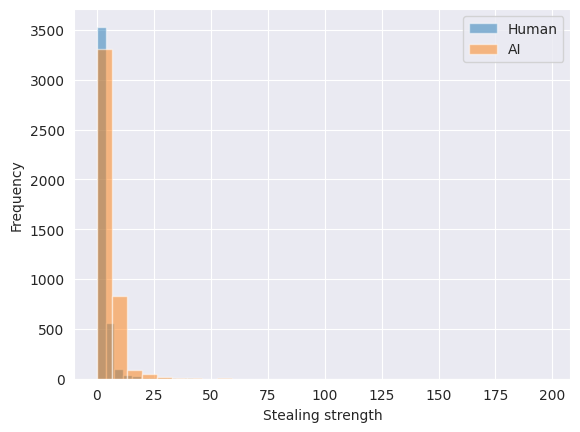

In [65]:
comparation_hist('stealing_strength', 'Stealing strength')

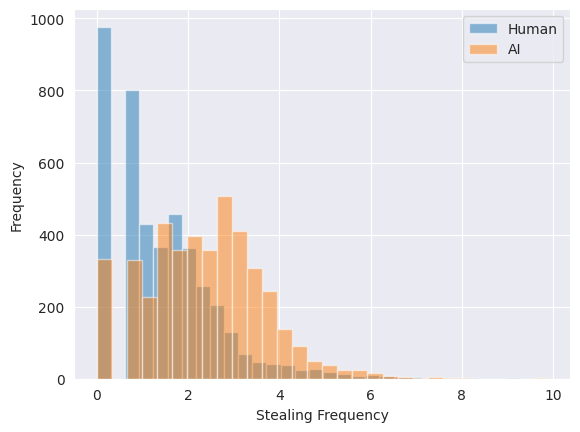

In [66]:
comparation_hist('stealing_frequency', 'Stealing Frequency')

### Feature: Answer Length
Even though I've limited maximum answer length of human- and ai- generated answers, the distribution might still be different. So another feature:
* `answer_length`

In [26]:
labeled_data['answer_length'] = np.log1p(labeled_data.answer.str.len())

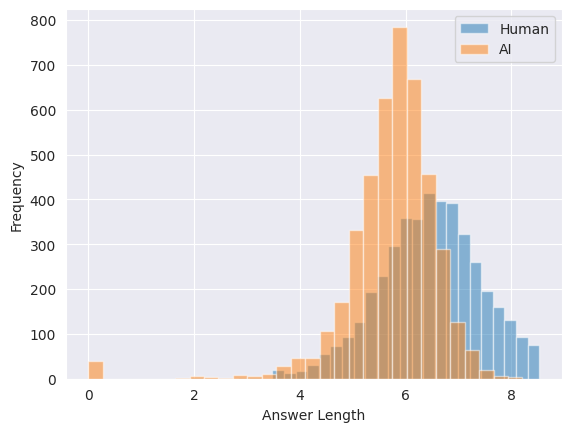

In [27]:
comparation_hist('answer_length', 'Answer Length')

### Feature: Sentence length

In [28]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/iliav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
labeled_data['sentences'] = labeled_data.answer.apply(sent_tokenize)
labeled_data['sentence_length_mean'] = np.log1p(labeled_data['sentences'].apply(lambda x: np.mean([len(s) for s in x])))

/home/iliav/Documents/workspaces/counter-ai/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


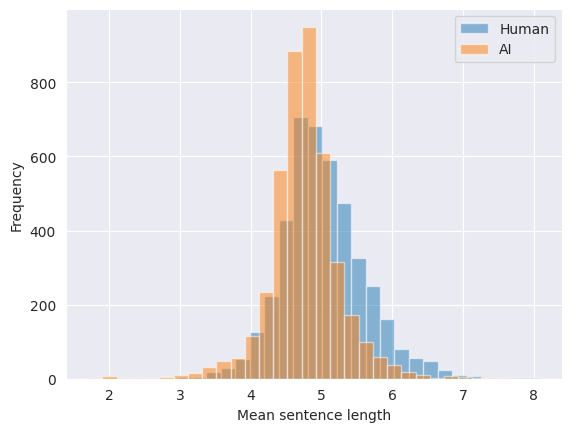

In [30]:
comparation_hist('sentence_length_mean', 'Mean sentence length')

In [31]:
labeled_data['sentence_length_std'] = np.log1p(labeled_data.sentences.apply(lambda x: np.std([len(s) for s in x])))

/home/iliav/Documents/workspaces/counter-ai/venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


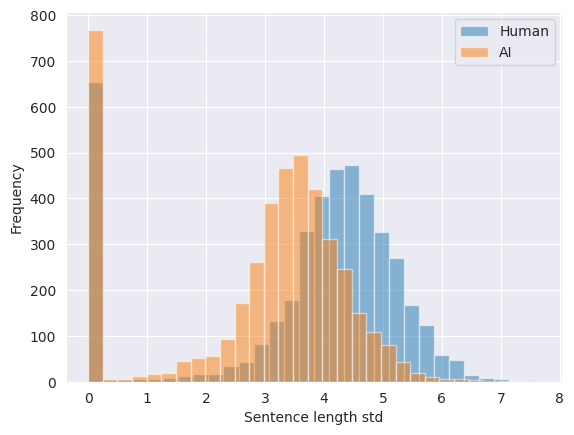

In [32]:
comparation_hist('sentence_length_std', 'Sentence length std')

### Features correlation

In [33]:
labeled_data = labeled_data.fillna(0)
new_features = ['answer_length', 'creativity', 'stealing_frequency', 'stealing_strength', 'sentence_length_std', 'sentence_length_mean', 'vocabulary_size']

<AxesSubplot: >

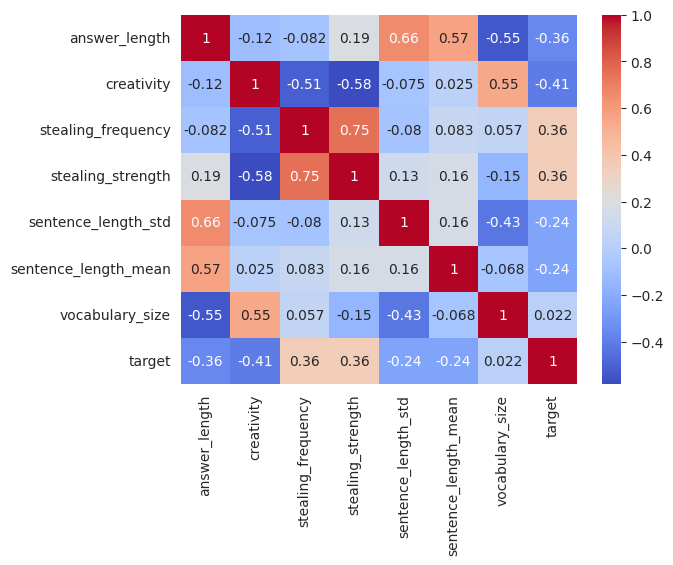

In [34]:
import seaborn as sns

sns.heatmap(labeled_data[new_features + ['target']].corr(), annot=True, cmap='coolwarm')

From this heatmap the following observations can be made:
* All features except `vocabulary_size` show significant correlation with target
* The following pairs show high correlation with each other:
    * `vocabulaty_size` and `creativity`
    * `stealing_frequency` and `creativity` (negative correlation)
    * `stealing_strength` and `creativity` (negative correlation)
    * `stealing_strength` and `stealing_frequency`
    * `answer_length` and `sentence_length_mean`
    * `answer_length` and `sentence_length_std`
* What's interesting is that despite the last two correlations `sentence_length_std` and `sentence_length_mean` do not correlate much
* However, the correlations do not seem to be too high, so it makes sense to try all the features

# Training models
I'm going to train several models and compare the results:
1. Logistic regression on the new features and select the best
2. Naive Bayes on vectorized answers
3. Combination of the previous two in two-layered pipeline

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from util.train_util import grid_search
from util.plot_util import plot_grid_results

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

## Data split

In [36]:
df_full_train, df_test = train_test_split(labeled_data, test_size=0.2, random_state=30)

## Logistic regression

In [37]:
lr = LogisticRegression(max_iter=500)
features = []
scores = []
for f in new_features:
    features.append(f)
    score = cross_val_score(lr, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,answer_length,0.668
1,creativity,0.801
2,stealing_frequency,0.797
3,stealing_strength,0.814
4,sentence_length_std,0.812
5,sentence_length_mean,0.824
6,vocabulary_size,0.834


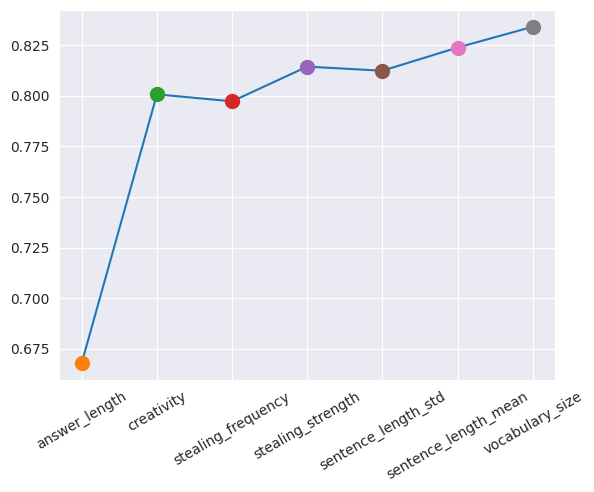

In [38]:
sns.lineplot(x=new_features, y=scores)
plt.xticks(rotation=30)
for i in range(len(new_features)):
    plt.plot(new_features[i], scores[i], 'o', markersize=10)

Conclusions:
* `stealing_frequency` and `sentence_length_std` do not add much to the performance and can be dropped
* surprisingly `vocabulary_size` does add some score points, despite it's low correlation with `target` and unconvincing histogram chart

In [39]:
selected_features = [f for f in new_features if f not in ['stealing_frequency', 'sentence_length_std']]
selected_features

['answer_length',
 'creativity',
 'stealing_strength',
 'sentence_length_mean',
 'vocabulary_size']

In [40]:
lr_tuning_grid = {
    'C': np.logspace(-3,2,6),
    'solver': ['lbfgs', 'liblinear', 'sag']
}
grid_search_results = grid_search(lr, lr_tuning_grid, df_full_train[selected_features], df_full_train.target)

Tuned Hyperparameters: {'C': 1.0, 'solver': 'lbfgs'}
F1 score : 0.8326308750727002


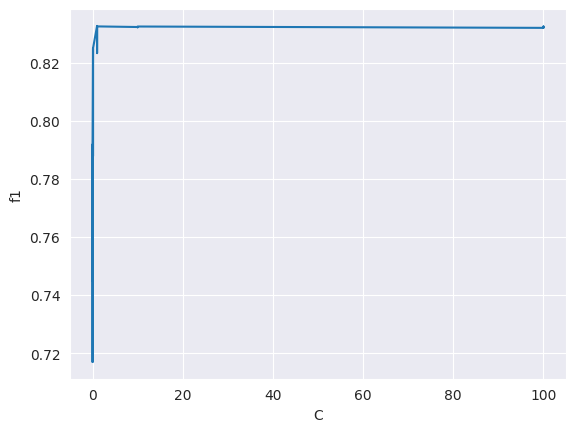

In [41]:
plot_grid_results(grid_search_results, x_var='C')

## Naive Bayes

In [42]:
count_vectorizer = CountVectorizer(min_df=10)
vectors = count_vectorizer.fit_transform(df_full_train.stemmed_answer)
vectors.shape

(6886, 3069)

In [43]:
nb = ComplementNB()
score = cross_val_score(nb, vectors, df_full_train.target, scoring='f1').mean()
score

0.831568482397361

In [44]:
nb_tuning_grid = {
    'alpha': np.logspace(-3,2,6)
}

grid_search_results = grid_search(nb, nb_tuning_grid, vectors, df_full_train.target)

Tuned Hyperparameters: {'alpha': 1.0}
F1 score : 0.831568482397361


In [45]:
%%time
nb_pipe_tuning_grid = {
    'c_vect__min_df': range(5, 10),
    'c_vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
}

nb_pipe = Pipeline([('c_vect', CountVectorizer(min_df=10)),
                     ('nb_proba', ComplementNB())])

grid_search_results = grid_search(nb_pipe, nb_pipe_tuning_grid, df_full_train.stemmed_answer, df_full_train.target)

Tuned Hyperparameters: {'c_vect__min_df': 6, 'c_vect__ngram_range': (1, 3)}
F1 score : 0.884553110754404
CPU times: user 2min 13s, sys: 1.16 s, total: 2min 14s
Wall time: 2min 14s


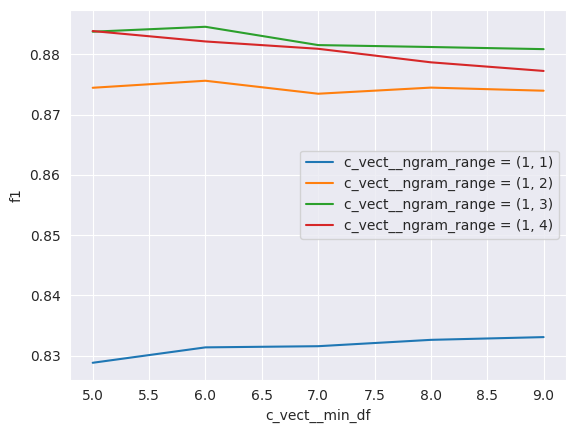

In [46]:
plot_grid_results(grid_search_results, x_var='c_vect__min_df', legend_var='c_vect__ngram_range')

## 2-Layered Pipeline
 Both Naive Bayes and Logistic Regression show good results. At the same time they use different aspects of data, so maybe it's possible to make them enhance each other.
So I plan to do the following:
1. Vectorize the `answer` column and train Naive Bayes on it
2. Apply Naive Bayes to the rows to predict probability `predict_proba()`.
3. Add this probability as another numerical feature to the data_frame
4. Combine this probability with `selected_features` and train Logistic Regression on the new set of numerical features

In [47]:
X_train = df_full_train[['stemmed_answer'] + selected_features]
y_train = df_full_train.target
X_test = df_test[['stemmed_answer'] + selected_features]
y_test = df_test.target

In order to do this trick, I need a custom transformer that wraps the Naive Bayes classifier and uses `predict_proba` in the `transform` method

In [48]:
class ComplementNBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.clf = ComplementNB()

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        probas = self.clf.predict_proba(X)
        return pd.DataFrame(np.array([x[1] for x in probas]), columns=['nb_probability'])

Now I'm creating the pipeline that implements the plan:

In [49]:
nb_pipe = Pipeline([('c_vect', CountVectorizer(min_df=7, ngram_range=(1, 3))),
                     ('nb_proba', ComplementNBTransformer())])

columns = [('nb_pipe', nb_pipe, 'stemmed_answer')]

col_trans = ColumnTransformer(columns, remainder = 'passthrough') # the `remainder` part ensures that `selected_features` are passed down the pipeline and later combined with the output of nb_pipe

full_pipe = Pipeline([('nb_col_trans', col_trans),
                     ('lr', LogisticRegression(C=10.0, solver='lbfgs', max_iter=500))])

cross_val_score(full_pipe, X_train, y_train, scoring='f1').mean()

0.9061685875967453

In [50]:
full_pipe.fit(X_train, y_train)
f1_score(full_pipe.predict(X_test), y_test)

0.9039812646370025

### Fine tuning the pipeline
Parameters of Naive Bayes and Logistic Regression have already been tuned, so here I'm only tuning the `min_df` parameter of CountVectorizer:

In [51]:
%%time
pipe_tuning_grid = {
    'lr__C': np.logspace(-3, 2, 6),
    'lr__solver': ['lbfgs', 'liblinear', 'sag']
}
grid_search_results = grid_search(full_pipe, pipe_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'lr__C': 10.0, 'lr__solver': 'lbfgs'}
F1 score : 0.9061685875967453
CPU times: user 2min 34s, sys: 18.7 s, total: 2min 52s
Wall time: 2min 29s


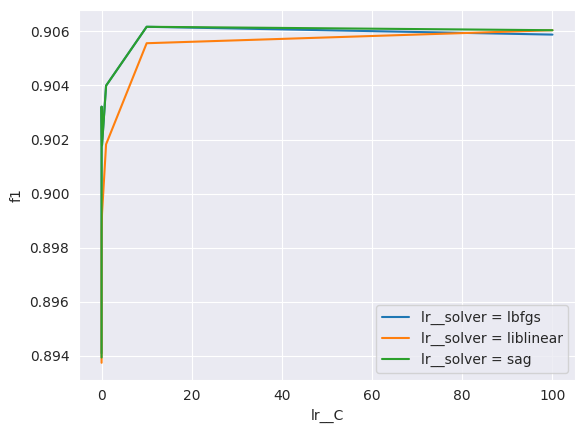

In [52]:
plot_grid_results(grid_search_results, x_var='lr__C', legend_var='lr__solver')

In [53]:
full_pipe.set_params(**{'lr__C': 8, 'lr__solver': 'liblinear'})
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('nb_col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nb_pipe',
                                                  Pipeline(steps=[('c_vect',
                                                                   CountVectorizer(min_df=7,
                                                                                   ngram_range=(1,
                                                                                                3))),
                                                                  ('nb_proba',
                                                                   ComplementNBTransformer())]),
                                                  'stemmed_answer')])),
                ('lr',
                 LogisticRegression(C=8, max_iter=500, solver='liblinear'))])

In [54]:
np.round(f1_score(full_pipe.predict(X_test), y_test), 3)

0.902